<a href="https://colab.research.google.com/github/Aminfaraji/predict_next_candlestick/blob/main/predict_next_candlestick.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import os
from glob import glob
import argparse
import cv2
import tensorflow as tf
import numpy as np
import pandas as pd
import csv
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import mplfinance as mplf

In [ ]:
# !pip install mplfinance

In [2]:
def windows_dataset(series,windows_size,buffer_size,batch_size):
    ds=tf.expand_dims(series,axis=-1)
    ds=tf.data.Dataset.from_tensor_slices(series)
    ds=ds.window(windows_size+1,shift=1,drop_remainder=True)
    ds=ds.flat_map(lambda w:w.batch(windows_size+1))
    ds=ds.shuffle(buffer_size)
    ds=ds.map(lambda w:(w[:-1],w[-1:]))
    ds=ds.batch(batch_size)
    return ds

In [8]:
data=pd.read_csv('EURUSD15_1.csv',delimiter='\t',header=None,index_col=0)
data=pd.DataFrame(data.values,columns=["Open","High","Low","Close","Volume"]).drop("Volume",axis=1)
# data

In [ ]:
# scale=MinMaxScaler()
# dataset_normalize=scale.fit_transform(dataset)

In [13]:
train_split=80000
train,test=train_test_split(data,test_size=.2,shuffle=False)

In [14]:
train_wind=windows_dataset(train,30,train_split,1)
test_wind=windows_dataset(test,30,20000,1)

In [9]:
# inp=tf.keras.Input((None,5))
# x=tf.keras.layers.Conv1D(64,3,activation='relu')(inp)
# x=tf.keras.layers.LSTM(64)(x)
# x=tf.keras.layers.LSTM(64,activation='relu',return_sequences=True)(x)
# x=tf.keras.layers.LSTM(64,activation='relu',return_sequences=True)(x)
# x=tf.keras.layers.Dense(32,activation='relu')(x)
# x=tf.keras.layers.Dense(32,activation='relu')(x)
# out=tf.keras.layers.Dense(5)(x)
# model=tf.keras.Model(inputs=inp,outputs=out)
# model.summary()
model=tf.keras.Sequential([
    tf.keras.layers.Conv1D(64,3,padding='causal',activation="relu",kernel_initializer='he_normal',input_shape=(None,4)),
    tf.keras.layers.Conv1D(64,3,padding='causal',activation="relu",kernel_initializer='he_normal'),
    tf.keras.layers.LSTM(64,return_sequences=True),
    tf.keras.layers.LSTM(64,return_sequences=True),
    tf.keras.layers.LSTM(10),
    tf.keras.layers.Dense(4,activation='linear')
    # tf.keras.layers.Lambda(lambda x : x*100)
])

In [16]:
# lr_schedule=tf.keras.callbacks.LearningRateScheduler(
#     lambda epoch : 1e-6*10**(epoch/20)
# )
optim=tf.keras.optimizers.SGD(learning_rate=1.5e-6,momentum=.9)
model.compile(optim,loss=tf.keras.losses.Huber(),metrics=['mae'])
# hist=model.fit(train_wind,epochs=5,callbacks=[lr_schedule])

In [ ]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "/content/drive/MyDrive/predict_candlestick/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

batch_size = 1

# Calculate the number of batches per epoch
import math
n_batches = train_split / batch_size
n_batches = math.ceil(n_batches)    # round up the number of batches to the nearest whole integer

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=2*n_batches)

# Create a new model instance
# model = create_model()

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# Train the model with the new callback
model.fit(train_wind,
          epochs=20,
          callbacks=[cp_callback],
          validation_data=test_wind,
          verbose=1)

Epoch 1/20
79970/79970 [==============================] - 850s 11ms/step - loss: 0.0020 - mae: 0.0536 - val_loss: 8.4092e-04 - val_mae: 0.0379
Epoch 2/20
79970/79970 [==============================] - 894s 11ms/step - loss: 0.0020 - mae: 0.0535 - val_loss: 8.3529e-04 - val_mae: 0.0378
Epoch 3/20
   55/79970 [..............................] - ETA: 12:03 - loss: 0.0020 - mae: 0.0544
Epoch 3: saving model to /content/drive/MyDrive/predict_candlestick/cp-0003.ckpt
79970/79970 [==============================] - 904s 11ms/step - loss: 0.0020 - mae: 0.0534 - val_loss: 8.3397e-04 - val_mae: 0.0377
Epoch 4/20
79970/79970 [==============================] - 886s 11ms/step - loss: 0.0020 - mae: 0.0533 - val_loss: 8.2513e-04 - val_mae: 0.0375
Epoch 5/20
  118/79970 [..............................] - ETA: 13:29 - loss: 0.0020 - mae: 0.0525
Epoch 5: saving model to /content/drive/MyDrive/predict_candlestick/cp-0005.ckpt
79970/79970 [==============================] - 861s 11ms/step - loss: 0.0020 - ma

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
last=tf.train.latest_checkpoint('/content/drive/MyDrive/predict_candlestick')
last

'/content/drive/MyDrive/predict_candlestick/cp-0005.ckpt'

In [19]:
# model.load_weights(last)
tf.config.run_functions_eagerly(True)
model.evaluate(test_wind)

19970/19970 [==============================] - 656s 33ms/step - loss: 8.2408e-04 - mae: 0.0375


[0.00082408293383196, 0.037480562925338745]

In [62]:
a=test_wind.take(1)
pred=model.predict(a)

1/1 [==============================] - 2s 2s/step


In [54]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_candle(x_pd):
  plt.figure()

  x_pd=pd.DataFrame(x_pd,columns=['open','high','low','close'])
  # "up" dataframe will store the stock_prices
  # when the closing stock price is greater
  # than or equal to the opening stock prices
  up = x_pd[x_pd.close >= x_pd.open]

  # "down" dataframe will store the stock_prices
  # when the closing stock price is
  # lesser than the opening stock prices
  down = x_pd[x_pd.close < x_pd.open]

  # When the stock prices have decreased, then it
  # will be represented by blue color candlestick
  col1 = 'blue'

  # When the stock prices have increased, then it
  # will be represented by green color candlestick
  col2 = 'green'

  # Setting width of candlestick elements
  width = .3
  width2 = .03

  # Plotting up prices of the stock
  plt.bar(up.index, up.close-up.open, width, bottom=up.open, color=col1)
  plt.bar(up.index, up.high-up.close, width2, bottom=up.close, color=col1)
  plt.bar(up.index, up.low-up.open, width2, bottom=up.open, color=col1)

  # Plotting down prices of the stock
  plt.bar(down.index, down.close-down.open, width, bottom=down.open, color=col2)
  plt.bar(down.index, down.high-down.open, width2, bottom=down.open, color=col2)
  plt.bar(down.index, down.low-down.close, width2, bottom=down.close, color=col2)

  # rotating the x-axis tick labels at 30degree
  # towards right
  plt.xticks(rotation=30, ha='right')

  # displaying candlestick chart of stock data
  # of a week
  plt.show()



In [70]:
x=list(a)[0][0].numpy()[0]
y=list(a)[0][1].numpy()[0]

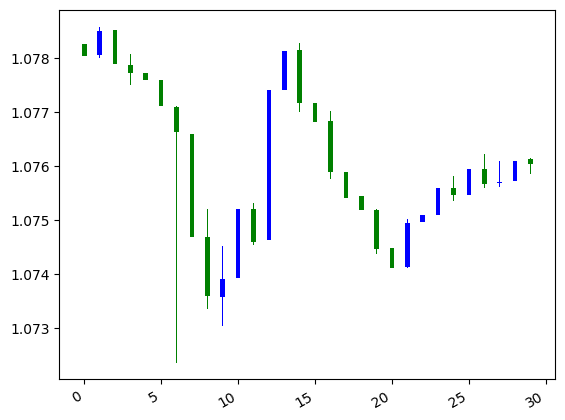

In [71]:
plot_candle(x)

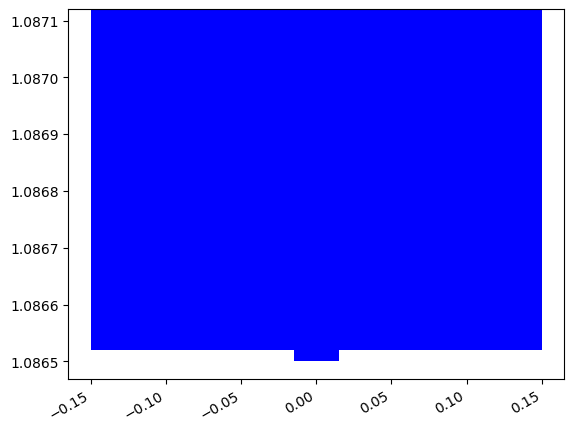

In [72]:
plot_candle(y)

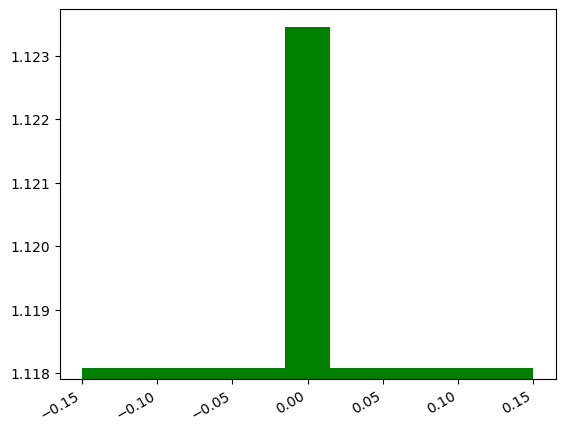

In [73]:
plot_candle(pred)

In [74]:
tf.losses.mae(y,pred)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.03261864], dtype=float32)>